# Introduction into Data Science - Assignment Part II

This is the second part of the assignment in IDS 2023/2024.

This part of the assignment consists of five questions — each of these questions is contained in a separate Jupyter notebook:
- [Question 1: Data Preprocessing](Q1_Preprocessing_Visualization.ipynb)
- [Question 2: Association Rules](Q2_Frequent_Itemsets_Association_Rules.ipynb)
- [Question 3: Process Mining](Q3_Process_Mining.ipynb)
- [Question 4: Text Mining](Q4_Text_Mining.ipynb)
- [Question 5: Big Data](Q5_Big_Data.ipynb)

Additional required files are in two folders.
- [datasets](datasets/)
- [scripts](scripts/)

Please use the provided notebook to work on the questions. When you are done, upload your version of each of the notebooks to Moodle. Your submission will, therefore, consist of five jupyter notebook and _no_ additional file. Any additionally provided files will not be considered in grading.
Enter your commented Python code and answers in the corresponding cells. Make sure to answer all questions in a clear and explicit manner and discuss your outputs. _Please do not change the general structure of this notebook_. You can, however, add additional markdown or code cells if necessary. Please **DO NOT CLEAR THE OUTPUT** of the notebook you are submitting! Additionally, please ensure that the code in the notebook runs if placed in the same folder as all of the provided files, delivering the same outputs as the ones you submit in the notebook. This includes being runnable in the bundled conda environment.

*Please make sure to include the names and matriculation numbers of all group members in the provided slots in each of the notebooks.* If a name or a student id is missing, the student will not receive any points.

Hint 1: **Plan your time wisely.** A few parts of this assignment may take some time to run. It might be necessary to consider time management when you plan your group work. Also, do not attempt to upload your assignment at the last minute before the deadline. This often does not work, and you will miss the deadline. Late submissions will not be considered.

Hint 2: RWTHMoodle allows multiple submissions, with every new submission overwriting the previous one. **Partial submissions are possible and encouraged.** This might be helpful in case of technical issues with RWTHMoodle, which may occur close to the deadline.

Hint 3: As a technical note. Some IDEs such as DataSpell may automatically strip jupyter notebook cell metadata. If you are able, please re-add it from the source notebooks before submission. This is necessary for our grading.

Enter your group number and members with matriculation numbers below.

In [235]:
GROUP_NO = 112 # group number
GROUP_MEMBERS = {
    451963: "Paul Väthjunker", # mat. no. : name,
    413004: "Touyen Nguyenova",
}

---

In [236]:
`# required imports
# do not edit!

import nltk
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import unicodedata
import multiprocessing
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.corpus import stopwords
from nltk.lm import MLE
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')  # omw = open multilingual wordnet
stopword_list = set(stopwords.words('english'))
reg_tokenizer = nltk.RegexpTokenizer(r"\w+")  # tokenizes and removes punctuation at the same time
snow_stemmer = SnowballStemmer('english')
wordnet_lemmatizer = WordNetLemmatizer();`

SyntaxError: invalid syntax (659405446.py, line 1)

# Question 4: Text Mining (23 pts)


## About the Data: Taylor Swift

In this task, our data consists of song lyrics from nine albums by Taylor Swift. Taylor Swift is one of the best-selling musicians and currently subject of various research. As she is known to venture into different musical genres and make artistic innovations for each album, we want to check whether we can support this claim using Text Mining.

Therefore, we:
1. Load the data and preprocess it first,
2. use the set of words for recognizing a lyric's album,
3. use Doc2Vec to check the similarity of albums and to cluster them,
4. and finally use language models that are based on n-grams to generate some own lyrics.

We aim to support our data analysis by reporting data and discussing results. 

## Data Loading and Preprocessing (7.5 Pts)

### a)
i. First things first. Import the file **q4_taylor_swift.csv** and save it into a dataframe named `swift_df`. Visualize the dataframe by showing the first five lines. 

_Note: In this question, every lyric is considered as a single document. The data contains lyrics from several albums. The order of the lyrics is preserved considering their album, song and within their song._


In [237]:
# Import and visualization.
swift_df = pd.read_csv("datasets\q4_taylor_swift.csv")
print(swift_df.head())

          album                                        lyric
0  Taylor Swift          He said the way my blue eyes shined
1  Taylor Swift  Put those Georgia stars to shame that night
2  Taylor Swift                       I said, "That's a lie"
3  Taylor Swift                  Just a boy in a Chevy truck
4  Taylor Swift         That had a tendency of gettin' stuck


ii. As a first step in preprocessing, normalize all unicode encodings using `unicodedata.normalize` with 'NKFD' as the form and remove all closing and opening brackets, i.e., '(' and ')'.

In [238]:
def preprocess_lyric(lyric):
    lyric = unicodedata.normalize('NFKD', lyric)
    lyric = lyric.replace('(', '').replace(')', '')
    return lyric

In [239]:
swift_df['lyric'] = swift_df['lyric'].apply(preprocess_lyric)
print(swift_df.head())

          album                                        lyric
0  Taylor Swift          He said the way my blue eyes shined
1  Taylor Swift  Put those Georgia stars to shame that night
2  Taylor Swift                       I said, "That's a lie"
3  Taylor Swift                  Just a boy in a Chevy truck
4  Taylor Swift         That had a tendency of gettin' stuck


### b)
We get a first idea of the data distribution over the albums by counting the lyrics in our data per album. Code the method `count_lyrics_per_album`.

In [240]:
def count_lyrics_per_album(input_df: pd.DataFrame) -> pd.Series:
    """ 
    Counts the lyrics for each album and stores them in a pandas series.
    :param input_df: A pandas dataframe containing album data and their lyrics.
    :return: The data containing the albums and the count of lyrics per album.
    """
    album_counts = input_df['album'].value_counts()
    return album_counts

In [241]:
# Using the predefined function to calculate the series of values
count_per_album = count_lyrics_per_album(swift_df)

# Transforming the series to a dataframe for visualization - feel free to check the series object
count_df = pd.DataFrame({'album': count_per_album.index, 'lyric count': count_per_album.values})
print(count_df)

                         album  lyric count
0  Fearless (Taylor’s Version)         1170
1         Red (Deluxe Edition)         1064
2                1989 (Deluxe)         1003
3                   reputation          985
4           Speak Now (Deluxe)          935
5                        Lover          932
6    evermore (deluxe version)          909
7    folklore (deluxe version)          722
8                 Taylor Swift          609


### c)
i. Next, we visualize the counted lyrics per album using a barplot. Write down your code in `plot_lyric_count`.

In [242]:
def plot_lyric_count(input_series: pd.Series):
    """ 
    Visualizes the number of lyrics for each album in a bar plot.
    :param input_series: A pandas series containing album data and their lyric counts.
    """
    input_series.plot(kind='bar', color='skyblue', edgecolor='black')
    mpl.pyplot.xlabel('Albums')
    mpl.pyplot.ylabel('Number of Lyrics')
    mpl.pyplot.title('Number of Lyrics per Album')
    mpl.pyplot.show()


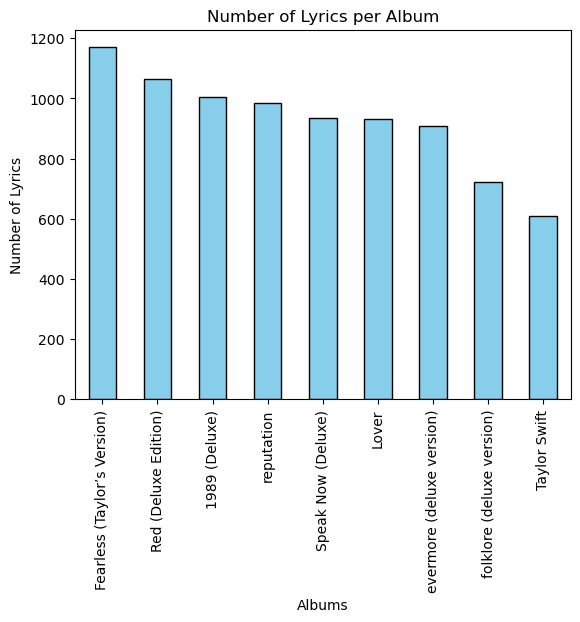

In [243]:
# Visualizing the data of 'count_per_album' as a bar plot using your function
plot_lyric_count(count_per_album)

ii. Is the data balanced enough for album classification?

__Student Answer:__ _your answer goes here_

### d)
In the following, we want to remove duplicate lyrics, as a song may contain a lyric more than once. Removing duplicates improves the interpretability of the further analysis and reduces an overfitting of the classification task on the duplicated lyrics. 

i. Therefore, as a first step, we remove all duplicate lyrics and keep only a single instance per duplicate lyric on each album. The obtained dataset has to be named `swift_df_proc`.

In [244]:
swift_df_proc = swift_df.drop_duplicates(subset=['album', 'lyric'])
print("\nProcessed DataFrame:")
print(swift_df_proc.head())


Processed DataFrame:
          album                                        lyric
0  Taylor Swift          He said the way my blue eyes shined
1  Taylor Swift  Put those Georgia stars to shame that night
2  Taylor Swift                       I said, "That's a lie"
3  Taylor Swift                  Just a boy in a Chevy truck
4  Taylor Swift         That had a tendency of gettin' stuck


ii. Do lyrics occur in several albums? If this is the case, remove them entirely as such a lyric is not suitable for our further questions. If this is not the case, give the code that shows so. Remember also to give a clear answer below. 

In [245]:
duplicate_lyrics = swift_df_proc['lyric'].duplicated(keep=False)

print("Lyrics occurring in several albums:")
print(swift_df_proc[duplicate_lyrics][['lyric', 'album']])

swift_df_proc = swift_df_proc[~duplicate_lyrics]
print("\nProcessed DataFrame:")
print(swift_df_proc.head())

Lyrics occurring in several albums:
                                                  lyric  \
216                                            Oh, yeah   
312                                      Oh, oh, oh, oh   
491                                            With you   
614                                            Oh, yeah   
631                                              Oh, oh   
743                                          Oh, oh, oh   
796                                            Oh-oh-oh   
871                          In the middle of the night   
1685                                         And I said   
1710                                         Ah, ah, ah   
1823                                         Yeah, yeah   
1972                                           Ooh, ooh   
2236  Nardo Wick 'Who Want Smoke??' Live Performance...   
2936                                         Oh, oh, oh   
3114                                           Oh-oh-oh   
3140                

__Student Answer:__ _your answer goes here_

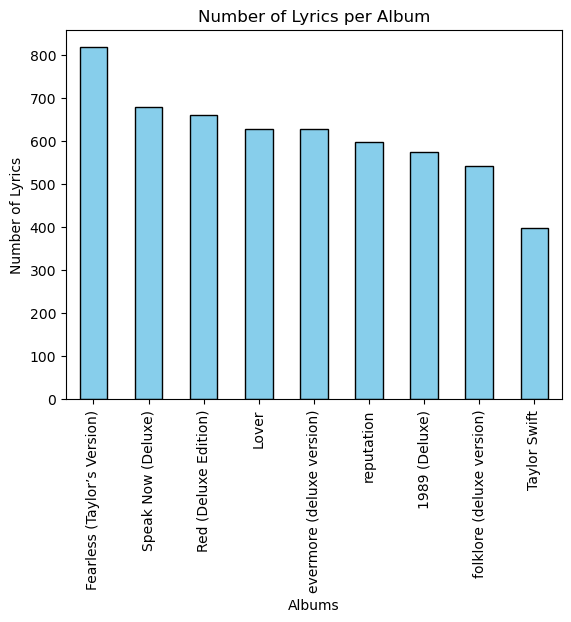

album
Fearless (Taylor’s Version)    818
Speak Now (Deluxe)             678
Red (Deluxe Edition)           660
Lover                          629
evermore (deluxe version)      629
reputation                     597
1989 (Deluxe)                  574
folklore (deluxe version)      542
Taylor Swift                   399
Name: count, dtype: int64

In [246]:
plot_lyric_count(count_lyrics_per_album(swift_df_proc))
count_lyrics_per_album(swift_df_proc)

### e)
The following tasks are more related to the preprocessing that has to be applied for the Text Mining context. First of all, we have to create a corpus. The obtained corpus should be named `corpus`. Make sure that each document in the corpus corresponds to exactly one lyric in `swift_df_proc`. 

In [247]:
# Creating the corpus
lyrics_corpus = swift_df_proc['lyric'].tolist()

print(lyrics_corpus[:5])
corpus = lyrics_corpus

['He said the way my blue eyes shined', 'Put those Georgia stars to shame that night', 'I said, "That\'s a lie"', 'Just a boy in a Chevy truck', "That had a tendency of gettin' stuck"]


### f)
Use the skeleton of the function `preprocessor_func` below to create a function that applies tokenization, stopword removal and lemmatization to an input string. The remaining tokens (after stopword removal and lemmatization) should be joined using a whitespace (' ').

In [248]:
def preprocessor_func(text: str) -> str:
    """
    Preprocesses a string using tokenization, stopword removal and lemmatization.
    :param text: A string to be preprocessed.
    :return: A joined string resulting from tokenization, stopword removal and lemmatization of an input string.
    """
    tokens = reg_tokenizer.tokenize(text.lower())  # Tokenization and convert to lowercase
    tokens = [wordnet_lemmatizer.lemmatize(token) for token in tokens if token not in stopword_list]  # Lemmatization and stopword removal
    
    processed_text = ' '.join(tokens)
    return processed_text

### g)
Now, create a preprocessed corpus `corpus_proc` by applying the preprocessing function to your corpus. For some tasks, we have to use the preprocessed corpus, and for some, the original corpus. This is indicated for each task.

In [249]:
# Corpus preprocessing
corpus_proc = [preprocessor_func(document) for document in corpus]

print(corpus_proc[:3])

['said way blue eye shined', 'put georgia star shame night', 'said lie']


### h)
In this task, we create all preprocessed data for all remaining tasks within the Text Mining question exercise.
For the later application of the set of words, we need to split the corpus.
First, we need to split our input data into a train and test set according to the Pareto rule (80% training set size and 20% test set size).
Therefore, split the dataframe `swift_df_proc` into a training and test set using the variable identifiers `df_train`, `df_test`, `y_train`, and `y_test`.
Further, make sure that distribution based on the "album" value is preserved.

In [250]:
random_seed = 42

X = swift_df_proc['lyric']
y = swift_df_proc['album']
df_train, df_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_seed)

print("Training set shape:", df_train.shape)
print("Test set shape:", df_test.shape)


Training set shape: (4420,)
Test set shape: (1106,)


### i)
Lastly, we create two further corpora, `corpus_train` and `corpus_test`, using the split data and the identical approach that is used before.

In [251]:
# print(df_train[:3])
# print(df_test[:3])

corpus_train = [preprocessor_func(document) for document in df_train]
corpus_test = [preprocessor_func(document) for document in df_test]

# print(corpus_train[:3])
# print(corpus_test[:3])

## Set of Words (6 Pts)

In this subtask, we use the set of words technique to distinguish and recognize different lyrics based on which album they belong to. Set of words encodes the documents by indicating for each word in our vocabulary whether the word occurs in the sentence or not.

### j)
Create a set of words encoding for the whole corpus. Use the previously defined preprocessor function `preprocessor_func` for our corpus `corpus`. 

In [252]:
# Creating a set of words using the propressor function and the corpus
sow = CountVectorizer(binary=True, preprocessor=preprocessor_func)
sow.fit(corpus)

CountVectorizer(binary=True,
                preprocessor=<function preprocessor_func at 0x00000193A960EE50>)

### k)
In the following, we want to have a first look at how the set of words classification works. Therefore, we apply the set of words to a line in the `swift_df`. Use the `apply_sow_to_line_by_index` function that is given an index of a lyric and that returns the original line, its preprocessed form, and its encoding resulting from the set of words implementation.
Comment below on what information the set of words representation contains.

In [253]:
def apply_sow_to_lyric_by_index(index: int) -> (str, str, _):
    """ 
    Applies set of words to a lyric in the swift_df.
    :param index: The index of the chosen lyric entry.
    :return: The function returns the chosen lyric, it preprocessed form and the set of words representation. 
    """
    original_lyric = corpus[index]
    preprocessed_lyric = preprocessor_func(original_lyric)
    encoding = sow.transform([preprocessed_lyric]).toarray()

    return original_lyric, preprocessed_lyric, encoding   
    

In [254]:
index = 13
line, line_p, line_sow = apply_sow_to_lyric_by_index(index)
print('Original line:     ', line)
print('Preprocessed line: ', line_p)
print('SoW encoding:\n', line_sow)

Original line:      I hope you think that little black dress
Preprocessed line:  hope think little black dress
SoW encoding:
 [[0 0 0 ... 0 0 0]]


In [255]:
vocabulary = sow.get_feature_names_out()
vocabulary

array(['16', '16th', '17', ..., 'york', 'young', 'younger'], dtype=object)

__Student Answer:__ _your answer goes here_

### l)
In this subtask, we use a **S**tochastic **G**radient **D**escent classifier to predict the album given a lyric for the corpus. Therefore, the steps to follow are briefly described below:
 1. First, we create a set of words encoding for the whole corpus. As we want to evaluate our results later using the test set, restrict yourself in the training to only use the training set `corpus_train`. 
 2. Train the classifier on the training set with 'album' as the target feature and 'log_loss' as the loss function.
 3. Predict the album for each line in the training and test set `corpus_test`.
 4. Calculate and show the accuracy for both the training and test set and store them in the variables `accuracy_train` and `accuracy_test`.

In [256]:
# Creating the set of words encoding
X_train = sow.fit_transform(corpus_train)
X_test = sow.transform(corpus_test)

In [257]:
# Train the classifier
classifier_sgd = SGDClassifier(loss='log_loss', random_state=42)
classifier_sgd.fit(X_train, y_train)

SGDClassifier(loss='log_loss', random_state=42)

In [258]:
# Predict the album
y_train_pred = classifier_sgd.predict(X_train)
y_test_pred = classifier_sgd.predict(X_test)

# y_test_pred

In [259]:
# Compute and show accuracy for training and test set
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

print("Accuracy on the Training Set:", accuracy_train)
print("Accuracy on the Test Set:", accuracy_test)

Accuracy on the Training Set: 0.7631221719457013
Accuracy on the Test Set: 0.31735985533453887


### m)
Given the accuracy values that you calculated in the last subtask, argue about the classifier's accuracy compared to a most frequent guessing classifier (i.e., a classifier that always chooses to predict the most frequent album). Use the distribution of lyrics over the albums calculated in task **a4)** to support your argument. 

__Student Answer:__ TODO

### n)
Next, we want to make our results more visual. Therefore, implement the `pred_album_by_index` method that takes a lyric's index as input, and based on that, returns the corresponding lyric, its actual album and its predicted album using the SGD classifier from **b3)**.

In [260]:
def pred_album_by_index(index: int) -> (str, str, str):
    """ 
    Predicts a lyric's album based on the .
    :param index: The index of the chosen lyric entry.
    :return: The function returns the chosen lyric, it preprocessed form and the set of words representation. 
    """
    original_lyric = corpus_test[index]
    actual_album = y_test.iloc[index]

    preprocessed_lyric = preprocessor_func(original_lyric)
    encoding = sow.transform([preprocessed_lyric])
    predicted_album = classifier_sgd.predict(encoding)[0]

    return original_lyric, actual_album, predicted_album

In [261]:
index = 14

In [262]:
lyric, album_actual, album_pred = pred_album_by_index(index)

print("Lyric:          ", lyric)
print("Actual album:   ", album_actual)
print("Predicted album:", album_pred)

Lyric:           open shut case
Actual album:    evermore (deluxe version)
Predicted album: evermore (deluxe version)


## Doc2Vec (4.5 pts)

In this subtask, we encode lyrics using Doc2Vec. Given the embedding, we reduce its dimensionality using **P**rincipal **C**omponent **A**nalysis while preserving the maximum amount of information so that we can visualize and cluster the embeddings in a scatter plot. Lastly, we have a manual look at the clusters to evaluate the information gain of the Doc2Vec approach.

### o) 
Initialize and train a Doc2Vec model based on the documents in the preprocessed corpus `corpus_p`. Set the vector dimension to 20 and min_count to 3.

In [263]:
# Calculating the number of cores available
cores = multiprocessing.cpu_count()

def preprocess_for_doc2vec(corpus):
    return [TaggedDocument(words=doc, tags=[str(i)]) for i, doc in enumerate(corpus)]

tagged_data = preprocess_for_doc2vec(corpus_proc)

vector_dimension = 20
min_count = 3
model_doc2vec = Doc2Vec(vector_size=vector_dimension, min_count=min_count, workers=cores)
model_doc2vec.build_vocab(tagged_data)
model_doc2vec.train(tagged_data, total_examples=model_doc2vec.corpus_count, epochs=30)

### p)
Create an embedding for each lyric in `swift_df_proc` and add all embeddings inferred to the `lyric_embeddings` list. This is a pretask for the next step that we take. 

In [264]:
lyric_embeddings = []
for preprocessed_lyric in swift_df_proc['lyric']:    
    words_list = preprocessed_lyric.split()
    embedding = model_doc2vec.infer_vector(words_list)
    lyric_embeddings.append(embedding)
lyric_embeddings

[array([-0.00572161, -0.01848602, -0.02347058,  0.01501527, -0.01674886,
         0.00291   , -0.01896116, -0.02314044, -0.00695297,  0.01378151,
        -0.00675304,  0.02129697, -0.02211066,  0.00370281, -0.00079593,
         0.02251778,  0.00801407, -0.02071868, -0.0004861 ,  0.01782431],
       dtype=float32),
 array([ 0.01885106,  0.00068745, -0.01857879, -0.00989936, -0.00784445,
         0.01456405,  0.00849708,  0.01831069,  0.003582  , -0.00532036,
        -0.02441149,  0.02329762, -0.00542848,  0.00665901,  0.01555181,
         0.02346232,  0.01530893, -0.00562985,  0.013355  , -0.00392195],
       dtype=float32),
 array([-0.04728749,  0.01080403,  0.01673275,  0.01093315,  0.08910292,
         0.00633574,  0.02551893,  0.11628624, -0.08829267,  0.03328376,
         0.0435243 , -0.03667615,  0.03760734, -0.05913727,  0.05147537,
        -0.00998524,  0.03669438,  0.02249371, -0.05454581, -0.01533622],
       dtype=float32),
 array([-0.08217455,  0.00071736,  0.02035542,  0.02

### q)
Store the data contained in `lyric_embeddings` in a dataframe `embeddings_df`.
Apply DBSCAN to the `embeddings_df`dataframe with `eps = 0.3` and `min_samples = 2` and create a scatterplot with seaborn that shows the clusters of the inferred vectors. To be able to visualize the data in a two-dimensional vector space, apply a **p**rinciple **c**omponent **a**nalysis that is able to reduce the dimensionality of input data. (You can learn more about the PCA in its [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)). The code for the PCA is provided.

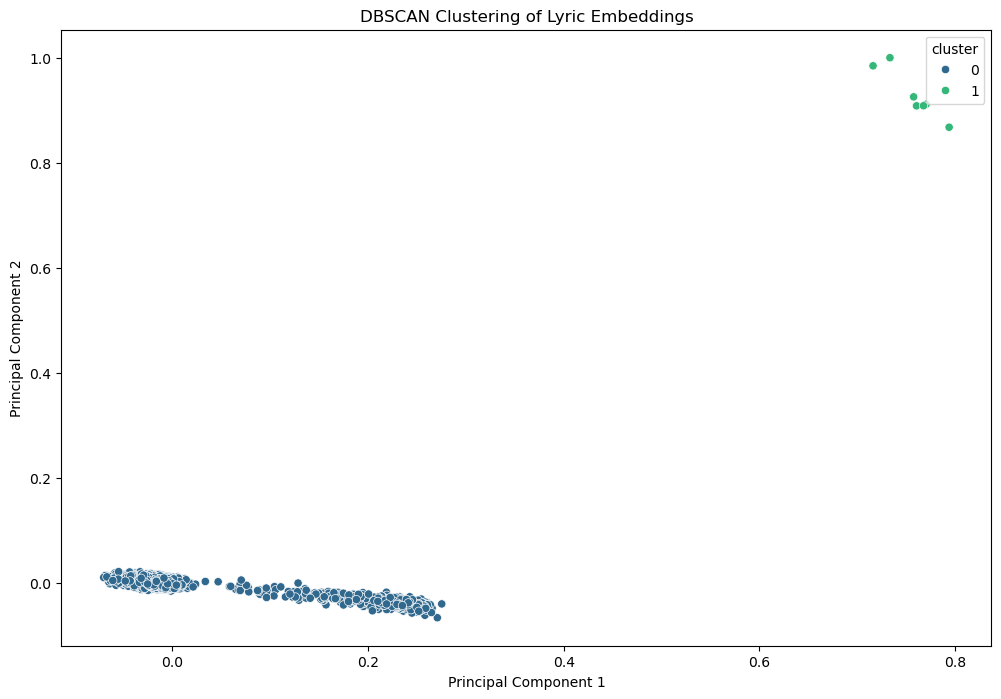

In [265]:
embeddings_df = pd.DataFrame(lyric_embeddings).astype(str)
dbscan = DBSCAN(eps=0.3, min_samples=2)
labels = dbscan.fit_predict(embeddings_df)
embeddings_df['cluster'] = labels
embeddings_df.columns = embeddings_df.columns.astype(str)

# Applying PCA to the embedding reducing the dimensionality to two
pca = PCA(n_components=2)
pca_embeddings = pd.DataFrame(pca.fit_transform(embeddings_df))

mpl.pyplot.figure(figsize=(12, 8))
sns.scatterplot(x=pca_embeddings[0], y=pca_embeddings[1], hue=embeddings_df['cluster'], palette='viridis', legend='full')
mpl.pyplot.title('DBSCAN Clustering of Lyric Embeddings')
mpl.pyplot.xlabel('Principal Component 1')
mpl.pyplot.ylabel('Principal Component 2')
mpl.pyplot.show()

### r)
Show lyrics from the original `swift_df` dataframe contained in two distinct clusters using the two cells below. Answer separately, whether you consider the lyrics in each cluster to be similar or dissimilar.

In [266]:
cluster_0_lyrics_indices = embeddings_df.loc[embeddings_df['cluster'] == 0].index
for idx in cluster_0_lyrics_indices:
    lyric = swift_df.loc[idx, 'lyric']
    print(f"Lyric {idx + 1}:\n{lyric}\n")

Lyric 1:
He said the way my blue eyes shined

Lyric 2:
Put those Georgia stars to shame that night

Lyric 3:
I said, "That's a lie"

Lyric 4:
Just a boy in a Chevy truck

Lyric 5:
That had a tendency of gettin' stuck

Lyric 6:
On back roads at night

Lyric 7:
And I was right there beside him all summer long

Lyric 8:
And then the time we woke up to find that summer gone

Lyric 9:
But when you think Tim McGraw

Lyric 10:
I hope you think my favorite song

Lyric 11:
The one we danced to all night long

Lyric 12:
The moon like a spotlight on the lake

Lyric 13:
When you think happiness

Lyric 14:
I hope you think that little black dress

Lyric 15:
Think of my head on your chest

Lyric 16:
And my old faded blue jeans

Lyric 17:
When you think Tim McGraw

Lyric 18:
I hope you think of me

Lyric 19:
September saw a month of tears

Lyric 20:
And thankin' God that you weren't here

Lyric 21:
To see me like that

Lyric 22:
But in a box beneath my bed

Lyric 23:
Is a letter that you never read



In [267]:
cluster_1_lyrics_indices = embeddings_df.loc[embeddings_df['cluster'] == 1].index
for idx in cluster_1_lyrics_indices:
    lyric = swift_df.loc[idx, 'lyric']
    print(f"Lyric {idx + 1}:\n{lyric}\n")

Lyric 635:
You pull me in and I'm a little more brave

Lyric 2459:
It jumps through your shirt

Lyric 2795:
Oh, red Red, red

Lyric 3977:
Ooh, your necklace hanging from my neck

Lyric 3994:
Twenty stitches in a hospital room

Lyric 4183:
We're a crooked love in a straight line down

Lyric 4279:
And time can heal, but this won't



__Student Answer:__ _your answer goes here_

## An N-Gram Based Language Model (4 Pts)

In this subtask, we use the `swift_df` data to create an n-gram based language model to generate new lyrics. Therefore, we play around with different values for n.

### s)
Write the `lyric_preprocessor` method that takes a lyric as input and that tokenizes it and makes each word lowercase.

In [268]:
def lyric_preprocessor(lyric: str) -> [str]:
    """
    Tokenizes a lyric and makes the tokens lowercase.
    :param lyric: A string containing an input lyric.
    :return: A list containing lowercase tokens of the input lyric.
    """
    tokens = nltk.word_tokenize(lyric)
    lowercase_tokens = [token.lower() for token in tokens]
    return lowercase_tokens

### t)
Apply the lyric_preprocessor to all lyrics in the `swift_df` and store the data in a `lyric_corpus` variable.

In [269]:
lyric_corpus = swift_df['lyric'].apply(lyric_preprocessor).tolist()

Next, train two n-grams with $n \in \{2,5\}$ on the lyric_corpus.

In [270]:
n_values = [2, 5]
ngram_models = {}

for n in n_values:
    ngrams, padded_ngrams = padded_everygram_pipeline(n, lyric_corpus)
    
    model = MLE(n)
    model.fit(ngrams, padded_ngrams)
    
    ngram_models[n] = model

### u)
i. Write the `generate_lyrics` method that takes an n-gram model and an integer for the number of lyrics to be generated as input and that returns a list of new lyrics that were generated using the given n-gram model.

In [271]:
import random
def generate_lyrics(n_gram_model, numb_of_new_lyrics: int) -> [str]:
    """
    Uses an n-gram model to generate several new lyrics.
    :param n_gram_model: An n-gram model. 
    :param numb_of_new_lyrics: The number of lyrics to be created.
    :return: As many generated lyrics as defined by the numb_of_new_lyrics.
    """ 

ii. Generate with the first and the second model ten lyrics each. Name one difference that you can find between the lyrics generated with 2-gram model and with the 5-gram model.

__Student Answer:__ _your answer goes here_